In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
ids_dictionary = {
    1: "Anticommensal Effect on\n Human Gut Microbiota",
    2: "Blood–brain-barrier penetration",
    3: "Oral Bioavailability",
    4: "AMES Mutagenecity",
    5: "Metabolic Stability",
    6: "Rat Acute LD50",
    7: "Drug-Induced Liver Inhibition",
    8: "HERG Cardiotoxicity",
    9: "Haemolytic Toxicity",
    10: "Myelotoxicity",
    11: "Urinary Toxicity",
    12: "Human Intestinal Absorption",
    13: "Hepatic Steatosis",
    14: "Breast Cancer Resistance Protein Inhibition",
    15: "Drug-Induced Choleostasis",
    16: "Human multidrug and toxin extrusion Inhibition",
    17: "Toxic Myopathy",
    18: "Phospholipidosis",
    19: "Human Bile Salt Export Pump Inhibition",
    20: "Organic anion transporting\n polypeptide 1B1 binding",
    21: "Organic anion transporting\n polypeptide 1B3 binding",
    22: "Organic anion transporting\n polypeptide 2B1 binding",
    23: "Phototoxicity human",
    24: "Phototoxicity in vitro",
    25: "Respiratory Toxicity",
    26: "P-glycoprotein Inhibition",
    27: "P-glycoprotein Substrate",
    28: "Mitochondrial Toxicity",
    29: "Carcinogenecity",
    30: "DMSO Solubility",
    31: "Human Liver Microsomal Stability",
    32: "Human Plasma Protein Binding",
    33: "hERG Liability",
    34: "Organic Cation\n Transporter 2 Inhibition",
    35: "Drug-induced Ototoxicity",
    36: "Rhabdomyolysis",
    37: "T1/2 Human",
    38: "T1/2 Mouse",
    39: "T1/2 Rat",
    40: "Cytotoxicity HepG2",  # "cell line",
    41: "Cytotoxicity NIH 3T3",  # "cell line",
    42: "Cytotoxicity HEK 293",  # "cell line",
    43: "Cytotoxicity CRL-7250",  # "cell line",
    44: "Cytotoxicity HaCat",  # "cell line",
    45: "CYP450 1A2 Inhibition",
    46: "CYP450 2C19 Inhibition",
    47: "CYP450 2C9 Inhibition",
    48: "CYP450 2D6 Inhibition",
    49: "CYP450 3A4 Inhibition",
    50: "pKa dissociation constant",
    51: "logD Distribution \ncoefficient (pH 7.4)",
    52: "logS",
    53: "Drug affinity to human serum albumin",
    54: "MDCK permeability",
    55: "50% hemolytic dose",
    56: "Skin penetration",
    57: "CYP450 2C8 Inhibition",
    58: "Aqueous Solubility",  # "(in phosphate saline buffer)",
}

In [3]:
coconut_folder = "/home/ec2-user/np-clinical-trials/fpadmet_results/COCONUT"
dds_folder = "/home/ec2-user/np-clinical-trials/fpadmet_results/DDS"

In [4]:
def process_data(input_folder):
    """
    While the confidence provides a measure of how likely a prediction is compared to all other possible classifications, the credibility measure (equal to the highest p-value of any one of the possible classifications being the true label) provides an indication of how good the training set is for classifying the given example.
    """
    results_list, names_list = [], []
    batch_dictionary = {}
    for files in os.listdir(input_folder):
        if not files.endswith(".txt") or not files.endswith("predicted.txt"):
            continue
        toxicity_name = ids_dictionary[int(files.split("_")[1].split(".")[0])]
        opened_data = pd.read_csv(os.path.join(input_folder, files), sep="\s+")
        opened_data["Category"] = toxicity_name
        if toxicity_name in batch_dictionary:
            batch_dictionary[toxicity_name] = pd.concat(
                [batch_dictionary[toxicity_name], opened_data], axis=0
            )
        else:
            batch_dictionary[toxicity_name] = opened_data
    for key in batch_dictionary:
        results_list.append(batch_dictionary[key])
        names_list.append(key)

    all_metrics = pd.concat(results_list, axis=0)
    return all_metrics, names_list

In [5]:
coconut_data, coconut_columns = process_data(coconut_folder)

In [6]:
synthethic_data, synthetic_columns = process_data(dds_folder)

In [7]:
non_case_relevant_columns = [
    "T1/2 Human",
    "T1/2 Mouse",
    "T1/2 Rat",
    "Rat Acute LD50",
    "Human Plasma Protein Binding",
    "Anticommensal Effect on\n Human Gut Microbiota",
    "Blood-brain-barrier penetration",
    "P-glycoprotein Inhibition",
    "P-glycoprotein Substrate",
    "DMSO Solubility",
    "Breast Cancer Resistance Protein Inhibition",
    "Organic anion transporting\n polypeptide 1B1 binding",
    "Organic anion transporting\n polypeptide 1B3 binding",
    "Organic anion transporting\n polypeptide 2B1 binding",
    "Organic anion transporting\n polypeptide 3B1 binding",
    "Metabolic Stability",
    "AMES Mutagenecity",
    "Oral Bioavailability",
    "Human intestinal absortion",
    "Organic Cation\n Transporter 2 Inhibition",
]

In [8]:
usable_columns = [x for x in coconut_columns if x not in non_case_relevant_columns]

In [9]:
coconut_data = coconut_data.loc[coconut_data["Category"].isin(usable_columns)].dropna(
    subset=["Credibility"]
)
synthethic_data = synthethic_data.loc[
    synthethic_data["Category"].isin(usable_columns)
].dropna(subset=["Credibility"])

In [10]:
coconut_data["Dataset"] = "COCONUT"
synthethic_data["Dataset"] = "DDS"
joint_data = pd.concat([coconut_data, synthethic_data], axis=0)

In [11]:
coconut_data_credible = coconut_data.loc[coconut_data["Credibility"] > 0.5]

In [12]:
synthethic_data_credible = synthethic_data.loc[synthethic_data["Credibility"] > 0.5]

In [13]:
print(f"COCONUT: {len(coconut_data_credible)}")
print(f"DDS: {len(synthethic_data_credible)}")

COCONUT: 5121625
DDS: 492687


In [14]:
toxicity_subsets = {}
for current_toxicity_category in usable_columns:
    current_toxicity_data = joint_data.loc[
        joint_data["Category"] == current_toxicity_category
    ]
    toxicity_subsets[current_toxicity_category] = current_toxicity_data

/home/ec2-user/np-clinical-trials/.venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ec2-user/np-clinical-trials/.venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/ec2-user/np-clinical-trials/.venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/ec2-user/np-clinical-trials

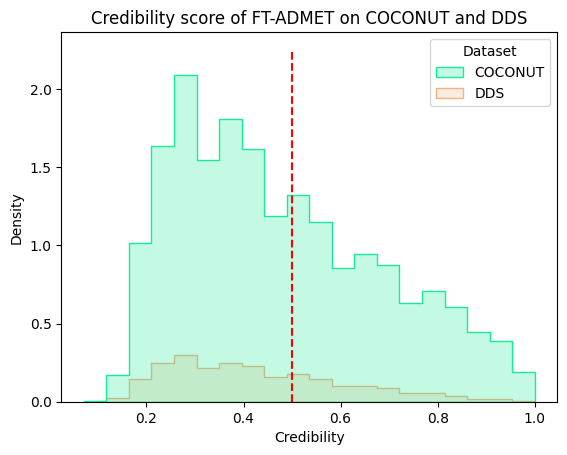

In [15]:
custom_colors = {"COCONUT": "#16EB96", "DDS": "#F4B183"}
sns.histplot(
    joint_data,
    x="Credibility",
    hue="Dataset",
    element="step",
    common_norm=True,
    stat="density",
    palette=custom_colors,
    bins=20,
)
plt.vlines(
    x=0.5,
    ymin=0,
    ymax=2.25,
    color="red",
    linestyle="--",
    label="Credibility threshold",
)
plt.title("Credibility score of FT-ADMET on COCONUT and DDS")
plt.savefig("credibility_score.png", format="png", dpi=600)

In [21]:
joint_data

,Predicted,Confidence,Credibility,Category,quantile_0.025,quantile_0.975,Dataset
CNP0000001,Yes,0.84,0.16,Blood–brain-barrier penetration,NaN,NaN,COCONUT
CNP0000002,No,0.99,0.51,Blood–brain-barrier penetration,NaN,NaN,COCONUT
CNP0000003,No,0.97,0.40,Blood–brain-barrier penetration,NaN,NaN,COCONUT
CNP0000004,No,0.97,0.40,Blood–brain-barrier penetration,NaN,NaN,COCONUT
CNP0000005,Yes,0.86,0.19,Blood–brain-barrier penetration,NaN,NaN,COCONUT
...,...,...,...,...,...,...,...
50235,Inactive,0.80,0.28,Cytotoxicity HaCat,NaN,NaN,DDS
50236,Inactive,0.87,0.33,Cytotoxicity HaCat,NaN,NaN,DDS
50237,Inactive,0.87,0.50,Cytotoxicity HaCat,NaN,NaN,DDS
50238,Inactive,0.95,0.76,Cytotoxicity HaCat,NaN,NaN,DDS


In [28]:
joint_data

,Predicted,Confidence,Credibility,Category,quantile_0.025,quantile_0.975,Dataset
CNP0000001,Yes,0.84,0.16,Blood–brain-barrier penetration,NaN,NaN,COCONUT
CNP0000002,No,0.99,0.51,Blood–brain-barrier penetration,NaN,NaN,COCONUT
CNP0000003,No,0.97,0.40,Blood–brain-barrier penetration,NaN,NaN,COCONUT
CNP0000004,No,0.97,0.40,Blood–brain-barrier penetration,NaN,NaN,COCONUT
CNP0000005,Yes,0.86,0.19,Blood–brain-barrier penetration,NaN,NaN,COCONUT
...,...,...,...,...,...,...,...
50235,Inactive,0.80,0.28,Cytotoxicity HaCat,NaN,NaN,DDS
50236,Inactive,0.87,0.33,Cytotoxicity HaCat,NaN,NaN,DDS
50237,Inactive,0.87,0.50,Cytotoxicity HaCat,NaN,NaN,DDS
50238,Inactive,0.95,0.76,Cytotoxicity HaCat,NaN,NaN,DDS


/home/ec2-user/np-clinical-trials/.venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ec2-user/np-clinical-trials/.venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ec2-user/np-clinical-trials/.venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ec2-user/np-clinical-trials/.venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na opti

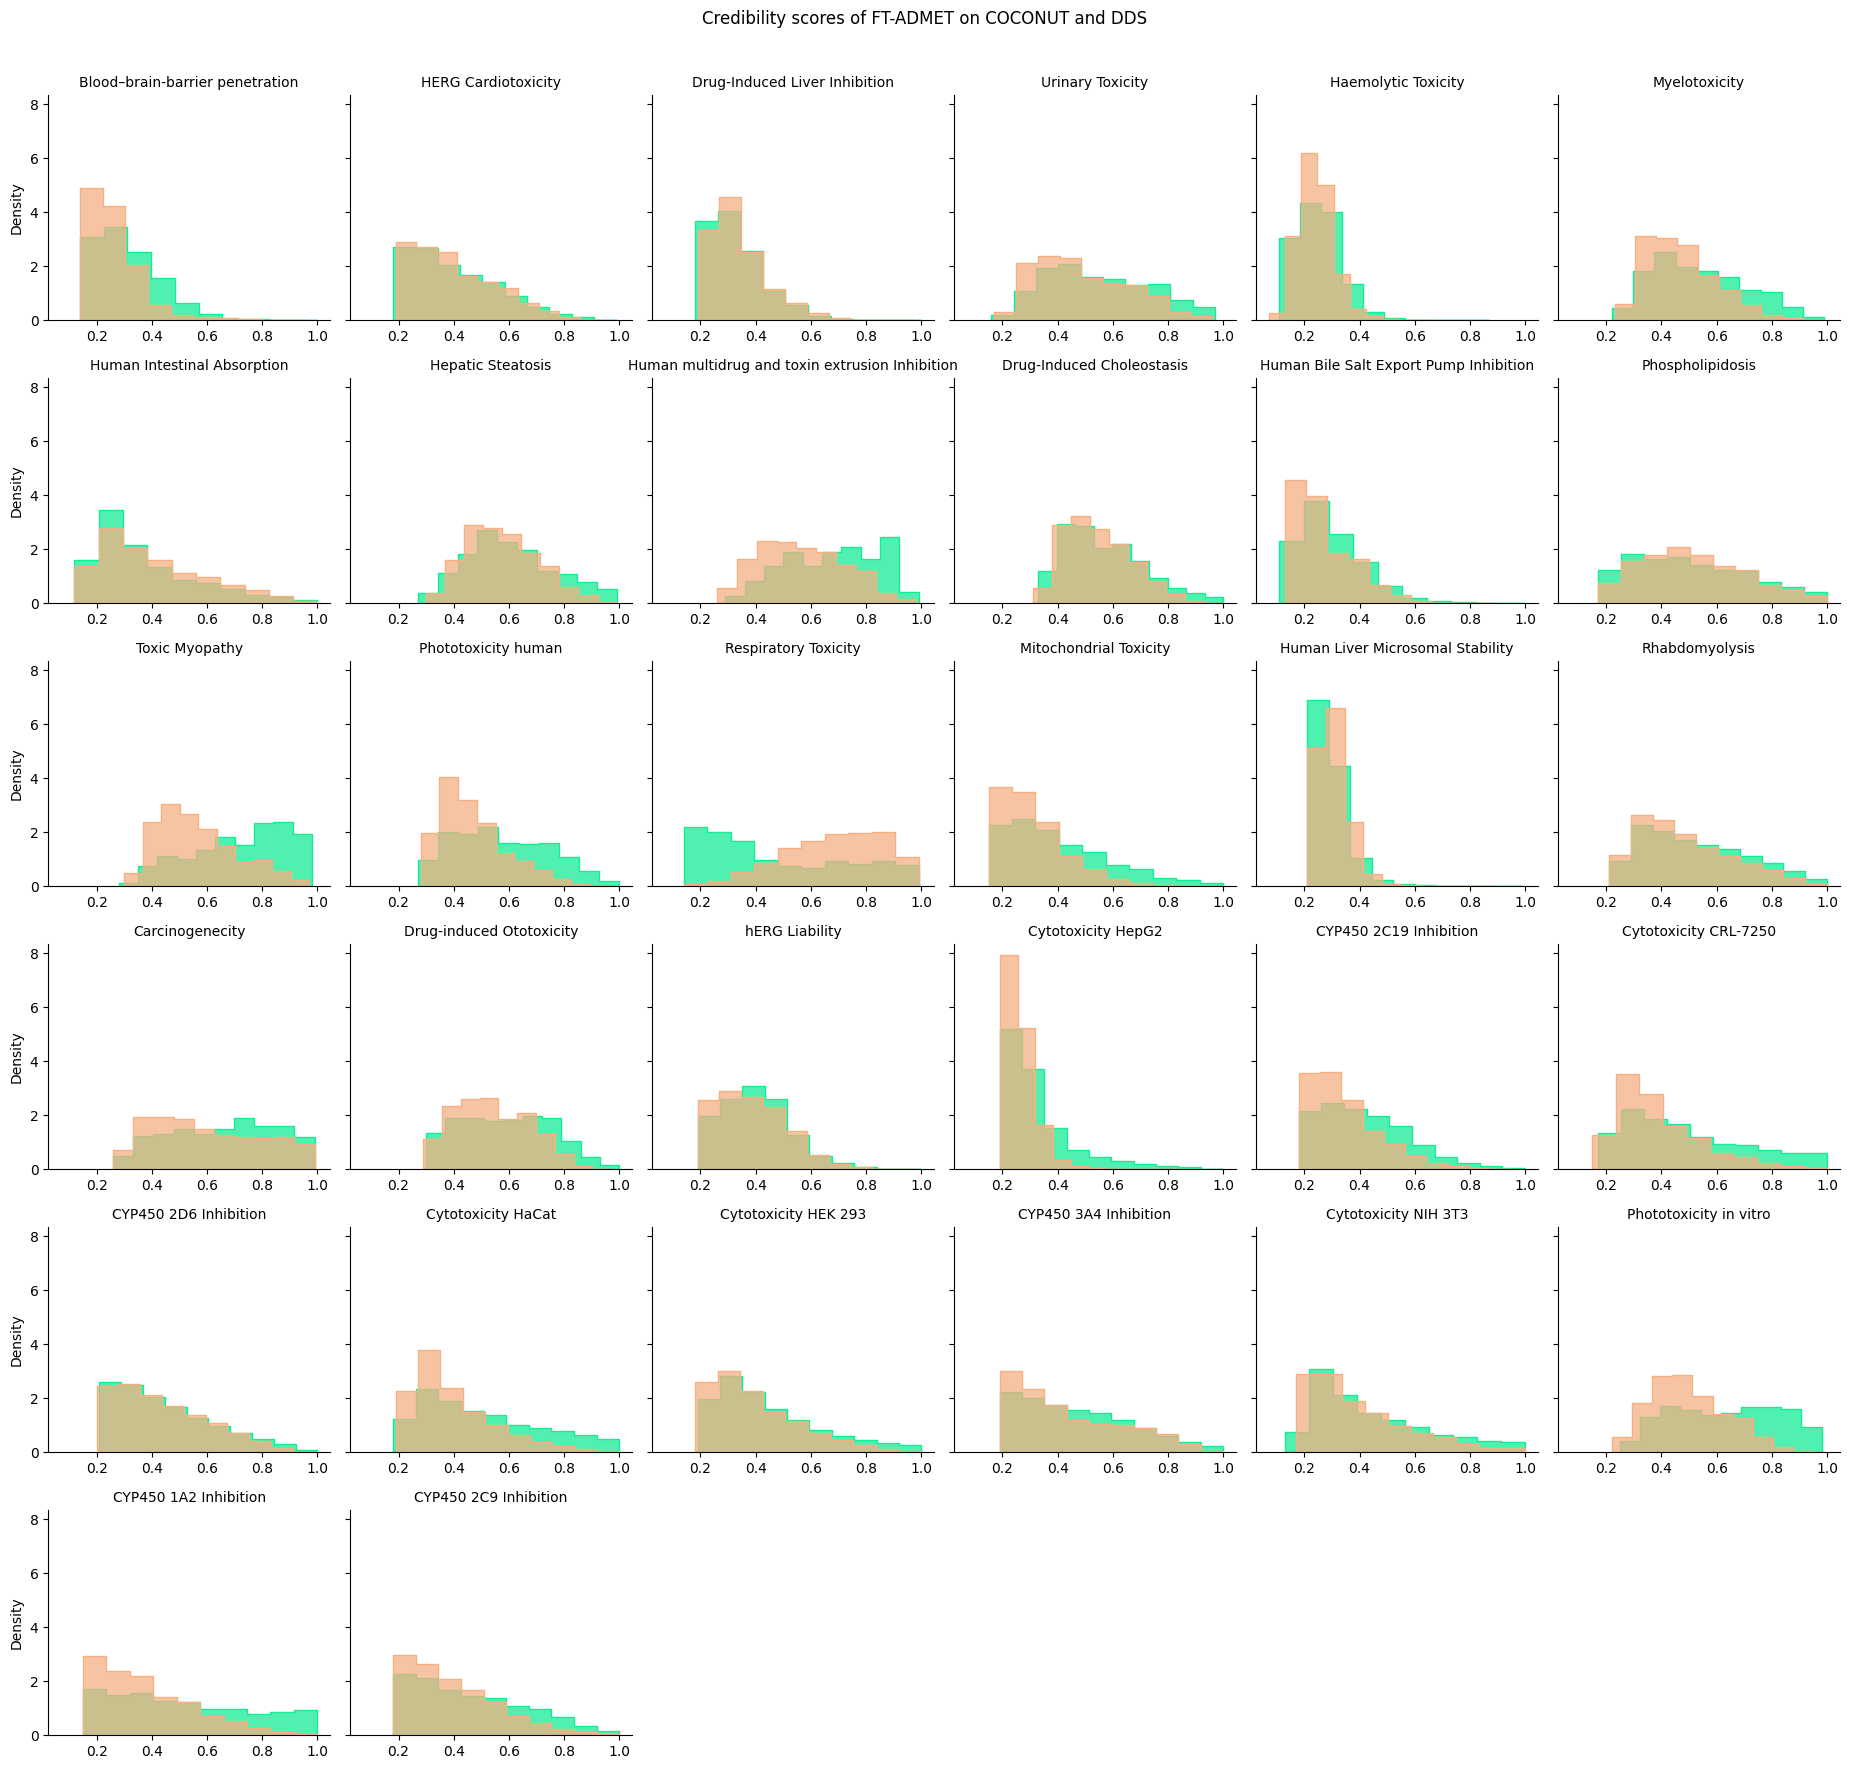

In [42]:
pannel_plot = (
    sns.FacetGrid(
        joint_data,
        col="Category",
        hue="Dataset",
        palette=custom_colors,
        col_wrap=6,
        sharex=True,
        sharey=True,
    )
    .map(
        sns.histplot,
        "Credibility",
        bins=10,
        element="step",
        common_norm=True,
        stat="density",
    )
    .add_legend()
)

sns.despine(top=True, right=True)


pannel_plot.set_titles(template="{col_name}")
pannel_plot.set_axis_labels("", "Density")

for ax in pannel_plot.axes.flatten():
    ax.tick_params(labelbottom=True)
pannel_plot._legend.remove()
plt.suptitle("Credibility scores of FT-ADMET on COCONUT and DDS")
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig("credibility_scores_pannel.png", format="png", dpi=600)